# Handle missing values in Categorical Features
In this notebook will be shown how to deal with categorical features with missing values.
It will be used the [Classified Ads for Cars](https://www.kaggle.com/mirosval/personal-cars-classifieds) dataset to predict the price of ADs through a simple model of Linear Regression. 

In order to show the various strategies and relevants pros / cons, we will focus on a particular categorical feature, the **maker**, the name of the brand of cars (Toyota, Kia, Ford, Bmw, ...). 

We will cover the following techniques:
* **Replace** missing values with the *most frequent values*. --It could lead to an unbalanced dataset.
* **Delete** rows with null values. --It could lead to a loss of too many useful informations.
* **Predict** values using a Classifier Algorithm (supervised or unsupervised)


## Steps of this notebook
* **Show Raw Data**: let's see how our dataset looks like.
* **Some Feature Engineering**: data cleaning and extraction of new features.
* **Models**: we will deal missing values comparing different techniques.
* **Conclusions**

## Show Raw Data

#### Importing Libraries

In [106]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

let's see how our dataset looks like

In [107]:
import zipfile

filename = "cars.csv"

with zipfile.ZipFile(filename + ".zip", 'r') as zip_ref:
    zip_ref.extractall("")

dtypes = {
    "maker": str, # brand name
    "model": str,
    "mileage": float,
    "manufacture_year": float,
    "engine_displacement": float,
    "engine_power": float,
    "body_type": str, # almost never present
    "color_slug": str, # also almost never present
    "stk_year": str,
    "transmission": str, # automatic or manual
    "door_count": str,
    "seat_count": str,
    "fuel_type": str, # gasoline, diesel
    "date_created": str, # when the ad was scraped
    "date_last_seen": str, # when the ad was last seen. Dataset policy was to remove all ads older than 60 days
    "price_eur": float} # list price converted to EUR

df = pd.read_csv(filename, dtype=dtypes)
raw_shape = df.shape
print(f"Raw data has {raw_shape[0]} rows, and {raw_shape[1]} columns")
df.head()

Raw data has 3552912 rows, and 16 columns


,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,color_slug,stk_year,transmission,door_count,seat_count,fuel_type,date_created,date_last_seen,price_eur
0,ford,galaxy,151000.0,2011.0,2000.0,103.0,NaN,NaN,None,man,5,7,diesel,2015-11-14 18:10:06.838319+00,2016-01-27 20:40:15.46361+00,10584.75
1,skoda,octavia,143476.0,2012.0,2000.0,81.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.853411+00,2016-01-27 20:40:15.46361+00,8882.31
2,bmw,NaN,97676.0,2010.0,1995.0,85.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.861792+00,2016-01-27 20:40:15.46361+00,12065.06
3,skoda,fabia,111970.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.872313+00,2016-01-27 20:40:15.46361+00,2960.77
4,skoda,fabia,128886.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.880335+00,2016-01-27 20:40:15.46361+00,2738.71


In [108]:
# Tons of missing values
print(df.isna().sum())

maker                   518915
model                  1133361
mileage                 362584
manufacture_year        370578
engine_displacement     743414
engine_power            554877
body_type              1122914
color_slug             3343411
stk_year               1708156
transmission            741630
door_count              614373
seat_count              749489
fuel_type              1847606
date_created                 0
date_last_seen               0
price_eur                    0
dtype: int64


In [109]:
# Here we can see strage data, like the Min() and the Max() of some features
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,mileage,manufacture_year,engine_displacement,engine_power,price_eur
count,3.19033e+06,3.18233e+06,2.8095e+06,2.99804e+06,3.55291e+06
mean,115814,2000.87,2043.96,98.468,1.62581e+06
std,342251,81.7259,1973.96,49.0731,2.02562e+09
min,0,0,0,1,0.04
25%,18800,2004,1400,68,1295.34
50%,86415,2009,1798,86,7364.91
75%,158025,2013,1997,110,16284.2
max,1e+07,2017,32767,2237,2.70615e+12


## Some Feature Engineering
Data cleaning and extraction of new features. 

In [110]:
df = df[df["price_eur"] != 1295.34]
df = df[df["price_eur"] > 150.00]

# Manufacture Year
year_of_scepticism = 1970
average_years = df.loc[df["manufacture_year"] >= year_of_scepticism].\
groupby(["maker", "model"])["manufacture_year"].mean().round().rename("avg_manufacture_year").reset_index()

df = df.merge(average_years, how="left", on=["maker", "model"])
df.loc[df["manufacture_year"] < year_of_scepticism, "manufacture_year"] = np.nan
df["manufacture_year"] = df["manufacture_year"].fillna(df["avg_manufacture_year"])
df = df[df['manufacture_year'].notna()]

# Engine Power
min_engine_power = 50
average = df.loc[df["engine_power"] >= min_engine_power].\
groupby(["maker", "model", "manufacture_year"])["engine_power"].mean().round().rename("avg_engine_power").reset_index()

df = df.merge(average, how="left", on=["maker", "model", "manufacture_year"])
df.loc[df["engine_power"] < min_engine_power, "engine_power"] = np.nan
df["engine_power"] = df["engine_power"].fillna(df["avg_engine_power"])
df = df[df['engine_power'].notna()]

# Engine Displacement
min_engine_displacement = 600
average = df.loc[df["engine_displacement"] >= min_engine_displacement].\
groupby(["maker", "model"])["engine_displacement"].mean().round().rename("avg_engine_displacement").reset_index()

df = df.merge(average, how="left", on=["maker", "model"])
df.loc[df["engine_displacement"] < min_engine_displacement, "engine_displacement"] = np.nan
df["engine_displacement"] = df["engine_displacement"].fillna(df["avg_engine_displacement"])
df = df[df['engine_displacement'].notna()]

# Mileage
average = df.groupby(["manufacture_year"])["mileage"].mean().round().rename("avg_mileage").reset_index()

df = df.merge(average, how="left", on=["manufacture_year"])
df["mileage"] = df["mileage"].fillna(df["avg_mileage"])

let's transform str dates in datetimes and creare a new feature with the duration of ADs

In [111]:
df['date_created'] = pd.to_datetime(df['date_created']).dt.normalize()
df['date_last_seen'] = pd.to_datetime(df['date_last_seen']).dt.normalize()
df['ad_duration'] = (df['date_last_seen'] - df['date_created']).dt.days # new feature: how much last the ad

**Replace** missing values with the *most frequent values*

In [112]:
# 
features_to_fillna = ["door_count", "seat_count"]
for feature in features_to_fillna:
    df[feature] = pd.to_numeric(df[feature], errors="coerce") # transform to numeric
    replace_with = df[feature].median()                       # deduction of the median
    df[feature].fillna(replace_with,inplace=True)             # replace null
    
df["seat_str"] = np.select(
    condlist=[
        (df["seat_count"] >= 0) & (df["seat_count"] < 4),
        (df["seat_count"] >= 4) & (df["seat_count"] < 6),
        (df["seat_count"] >= 6)],
    choicelist=[
        "small",
        "medium",
        "large",
        ],
    default="unknown")
# for col in ["seat_str"]:
#     print(col,": ",len(df[col].unique()) , " labels")
df = pd.get_dummies(df,columns=["seat_str"])
df = df.drop(["seat_count"], axis=1)
df = df.drop(["door_count"], axis=1)

**Delete** rows with null values.

In [113]:
#
df = df[df['fuel_type'].notna()]
df = pd.get_dummies(df,columns=["fuel_type"])
#size_mapping = {"diesel":0,"gasoline":1}
#df["fuel_type"] = df["fuel_type"].map(size_mapping)

df = df[df['transmission'].notna()]
df = pd.get_dummies(df,columns=["transmission"])
#size_mapping = {"man":0,"auto":1}
#df["transmission"] = df["transmission"].map(size_mapping)

In [114]:
# drop features
features_to_drop = ["model", "body_type", "color_slug", "stk_year", "avg_manufacture_year", "date_created", "date_last_seen", "avg_engine_displacement","avg_engine_power","avg_mileage"]
df = df.drop(features_to_drop, axis="columns")

Now that we've cleaned all the features, with the exception of the *maker*, let's see how they look like

In [115]:
df.head()

,maker,mileage,manufacture_year,engine_displacement,engine_power,price_eur,ad_duration,seat_str_large,seat_str_medium,seat_str_small,fuel_type_diesel,fuel_type_gasoline,transmission_auto,transmission_man
0,ford,151000.0,2011.0,2000.0,103.0,10584.75,74,1,0,0,1,0,0,1
1,skoda,143476.0,2012.0,2000.0,81.0,8882.31,74,0,1,0,1,0,0,1
2,bmw,97676.0,2010.0,1995.0,85.0,12065.06,74,0,1,0,1,0,0,1
3,skoda,111970.0,2004.0,1200.0,63.0,2960.77,74,0,1,0,0,1,0,1
4,skoda,128886.0,2004.0,1200.0,63.0,2738.71,74,0,1,0,0,1,0,1


In [116]:
# Missing values
print(df.isna().sum())

maker                  212975
mileage                     0
manufacture_year            0
engine_displacement         0
engine_power                0
price_eur                   0
ad_duration                 0
seat_str_large              0
seat_str_medium             0
seat_str_small              0
fuel_type_diesel            0
fuel_type_gasoline          0
transmission_auto           0
transmission_man            0
dtype: int64


In [117]:
# import matplotlib.pyplot as plt
# df_no_maker = df.copy()
# df_no_maker = df_no_maker.drop("maker", axis="columns")

# corr = df_no_maker.corr()
# plt.subplots(figsize=(15,10))
# sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, )

Now we just have to handle the **maker** feature, and we will do it with four different ways. Then, for each of them, we will create a simple model of Linear Regression for the prediction.

* **1st Model**: Delete the entire column *Maker*.
* **2nd Model**: Replace values with the mode.
* **3rd Model**: Delete rows with null values.
* **4th Model**: Predict the missing values with the RandomForestClassifier.

In [118]:
mse_list = []
r2_score_list = []
num_records_list = []

def remove_outliers(dataframe):
    '''
    return a dataframe without rows that are outliers in any column
    '''
    return dataframe\
    .loc[:, lambda df: df.std() > 0.04]\
    .loc[lambda df: (np.abs(stats.zscore(df)) < 3).all(axis=1)]

def plot_regression(Y_test, Y_pred):
    x = Y_test
    y = Y_pred

    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.plot(x, y, 'o')

    m, b = np.polyfit(x, y, 1)

    plt.plot(x, m*x + b)

## Delete the entire column *Maker*.
Our first try will be to create a model without the column *Maker*, leaving the number of rows unchanged. This "no-deal" practice is needed when the large amount of missing data threatens to invalidate the entire feature.

With this scenario we will probably have the worst scores on metrics.
 

In [119]:
df_no_maker = df.copy()
# drop of the feature maker
df_no_maker = df_no_maker.drop("maker", axis="columns")

df_no_maker = remove_outliers(df_no_maker)

X = df_no_maker.drop("price_eur", axis=1).values
Y = np.log1p(df_no_maker["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)

ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

mse_list.append(mean_squared_error(Y_test, Y_pred))
r2_score_list.append(r2_score(Y_test, Y_pred))
num_records_list.append(df_no_maker.shape[0])

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))
print("Remaining rows: "+ str(df_no_maker.shape[0]))

MSE: 0.15850525627451892
R2 score: 0.8293182451900453
Remaining rows: 852731


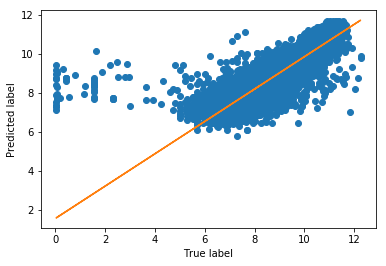

In [120]:
plot_regression(Y_test, Y_pred)

In [121]:
df_no_maker.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,mileage,manufacture_year,engine_displacement,engine_power,price_eur,ad_duration,seat_str_large,seat_str_medium,seat_str_small,fuel_type_diesel,fuel_type_gasoline,transmission_auto,transmission_man
count,852731,852731,852731,852731,852731,852731,852731,852731,852731,852731,852731,852731,852731
mean,87918.2,2009.56,1808.73,98.0122,13311.5,45.2159,0,1,0,0.497205,0.502795,0.282246,0.717754
std,79893.6,5.1255,564.499,37.6969,11053.1,47.5306,0,0,0,0.499992,0.499992,0.450093,0.450093
min,0,1993,600,50,0.04,0,0,1,0,0,0,0,0
25%,16500,2006,1397,71,5440.41,10,0,1,0,0,0,0,0
50%,73037,2011,1690,90,10990,30,0,1,0,0,1,0,1
75%,143059,2014,1995,115,18025.7,61,0,1,0,1,1,1,1
max,800000,2016,5828,252,230009,180,0,1,0,1,1,1,1


## Replace missing values with the most frequent data.
A certainly more effective method is to assign the missing values with the most frequent data, the mode. But be careful that this could lead to an unbalanced dataset, in case the missing values are a considerable number.


In [122]:
df_replace_mode = df.copy()

replace_with = df_replace_mode["maker"].mode()             # deduction of the mode
df_replace_mode["maker"].fillna(replace_with,inplace=True) # replace null

df_replace_mode = pd.get_dummies(df_replace_mode,columns=["maker"])

df_replace_mode = remove_outliers(df_replace_mode)

X = df_replace_mode.drop("price_eur", axis=1).values
Y = np.log1p(df_replace_mode["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)

ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

mse_list.append(mean_squared_error(Y_test, Y_pred))
r2_score_list.append(r2_score(Y_test, Y_pred))
num_records_list.append(df_replace_mode.shape[0])

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))
print("Remaining rows: "+str(df_replace_mode.shape[0]))

MSE: 0.12930635040402044
R2 score: 0.8438668497317605
Remaining rows: 187327


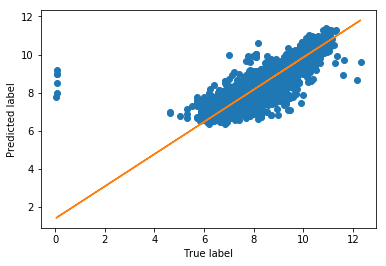

In [123]:
plot_regression(Y_test, Y_pred)

## Delete rows with null values.
Another option is to delete rows that have null values. Absolutely not recommended if our dataset is very small, but easily feasible if there are missing only a few values or if we have a very large dataset


In [124]:
df_del_rows = df.copy()

df_del_rows = df_del_rows[df_del_rows['maker'].notna()]
df_del_rows = pd.get_dummies(df_del_rows,columns=["maker"])

df_del_rows = remove_outliers(df_del_rows)

X = df_del_rows.drop("price_eur", axis=1).values
Y = np.log1p(df_del_rows["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)

ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

mse_list.append(mean_squared_error(Y_test, Y_pred))
r2_score_list.append(r2_score(Y_test, Y_pred))
num_records_list.append(df_del_rows.shape[0])

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))
print("Remaining rows: "+str(df_del_rows.shape[0]))

MSE: 0.12654022005151228
R2 score: 0.8736516284440504
Remaining rows: 293669


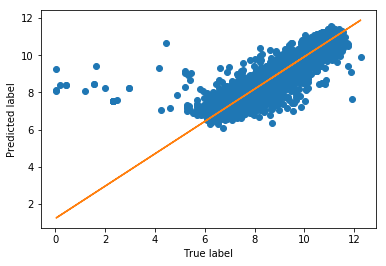

In [125]:
plot_regression(Y_test, Y_pred)

In [126]:
df_del_rows.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,mileage,manufacture_year,engine_displacement,engine_power,price_eur,ad_duration,seat_str_large,seat_str_medium,seat_str_small,fuel_type_diesel,...,maker_opel,maker_porsche,maker_rover,maker_seat,maker_skoda,maker_smart,maker_subaru,maker_suzuki,maker_toyota,maker_volvo
count,293669,293669,293669,293669,293669,293669,293669,293669,293669,293669,...,293669,293669,293669,293669,293669,293669,293669,293669,293669,293669
mean,97396.3,2009.34,2067.21,118.149,17002.9,43.8797,0,1,0,0.577456,...,0.22588,0,0,0,0,0,0,0,0,0
std,82734.1,5.34118,611.463,42.2364,13257.8,46.6812,0,0,0,0.493965,...,0.418161,0,0,0,0,0,0,0,0,0
min,0,1993,600,50,0.04,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
25%,24100,2006,1598,85,6981.05,10,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
50%,84450,2011,1991,110,14706.5,29,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
75%,153000,2014,2184,137,23525.7,61,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
max,800000,2016,6020,263,230009,180,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0


## Predict the missing values.
The most interesting approach is for sure the predicting of missing values with a classification algorithm. This will give us the opportunity not to waste a good chunk of the dataset, and therefore a large amount of information. If our predictions are accurate enough with this technique we should have the best metric scores.

Therefore:
- we have to split the dataset between rows with the column *maker* valorized, and rows with null values.
- the first dataset will become the dataset on which we will create the classification model with the *maker* as target feature.
- use the model thus created to predict the missing values from the dataset with null values
- merge the two dataset into one.



Let's divide the dataset in two

In [127]:
df_with_maker = df[df['maker'].notna()]
print("N. rows with maker not null", df_with_maker.shape[0])
# df_with_maker.info(null_counts=True)

df_no_maker = df[df['maker'].isna()]
print("N. rows with maker null", df_no_maker.shape[0])
# df_no_maker.info(null_counts=True)

N. rows with maker not null 747694
N. rows with maker null 212975


Let's use the first dataset to create the model

maker :  38  labels
ACCURACY: TRAIN=0.9615 TEST=0.9231
LOG LOSS: 0.27949031395594276


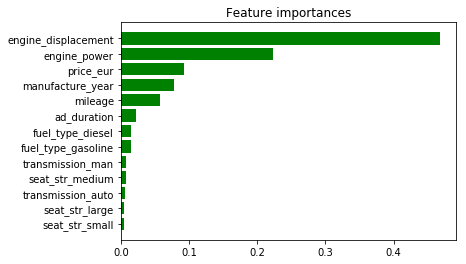

In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

for col in ["maker"]:
    print(col,": ",len(df[col].unique()) , " labels")

X = df_with_maker.drop("maker", axis=1).values
Y = df_with_maker["maker"].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

forest = RandomForestClassifier(n_estimators=45, max_depth=25, random_state=False, 
                                max_features=0.6, min_samples_leaf=3, n_jobs=-1)

forest.fit(X_train, Y_train)

y_pred_train = forest.predict(X_train)
y_pred = forest.predict(X_test)

y_pred_proba = forest.predict_proba(X_test)

accuracy_train = accuracy_score(Y_train, y_pred_train)
accuracy_test = accuracy_score(Y_test, y_pred)

print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train,accuracy_test))
print("LOG LOSS: "+str(log_loss(Y_test, y_pred_proba)))

importances = forest.feature_importances_
indices = list(np.argsort(importances))[::-1]
# print(indices)

plt.title("Feature importances")
plt.barh(range(len(indices)), importances[indices], color="g", align="center")
plt.yticks(range(len(indices)), df_with_maker.iloc[:, 1:].columns[indices])
# plt.ylim([-1, len(indices)])
plt.gca().invert_yaxis()

fill the 2nd dataframe with the prediction...

In [129]:
df_no_maker = df_no_maker.drop('maker', axis=1)
prediction = forest.predict(df_no_maker)

df_no_maker.insert(0, 'maker', prediction)

...and then, merge the two dataframe togheter

In [130]:
frames = [df_with_maker, df_no_maker]
df_final = pd.concat(frames)
print(df_final.shape[0])
df_final.head()

960669


,maker,mileage,manufacture_year,engine_displacement,engine_power,price_eur,ad_duration,seat_str_large,seat_str_medium,seat_str_small,fuel_type_diesel,fuel_type_gasoline,transmission_auto,transmission_man
0,ford,151000.0,2011.0,2000.0,103.0,10584.75,74,1,0,0,1,0,0,1
1,skoda,143476.0,2012.0,2000.0,81.0,8882.31,74,0,1,0,1,0,0,1
2,bmw,97676.0,2010.0,1995.0,85.0,12065.06,74,0,1,0,1,0,0,1
3,skoda,111970.0,2004.0,1200.0,63.0,2960.77,74,0,1,0,0,1,0,1
4,skoda,128886.0,2004.0,1200.0,63.0,2738.71,74,0,1,0,0,1,0,1


In [131]:
#df_final.sort_values(by=['price_eur'], inplace=True, ascending=False)

In [132]:
df_final = pd.get_dummies(df_final,columns=["maker"])

df_final = remove_outliers(df_final)

X = df_final.drop("price_eur", axis=1).values
Y = np.log1p(df_final["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)

ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

mse_list.append(mean_squared_error(Y_test, Y_pred))
r2_score_list.append(r2_score(Y_test, Y_pred))
num_records_list.append(df_final.shape[0])

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))
print("Remaining rows: "+str(df_final.shape[0]))

MSE: 0.1293104045119514
R2 score: 0.8389436865262994
Remaining rows: 243278


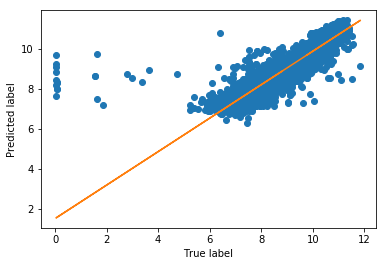

In [133]:
plot_regression(Y_test, Y_pred)

## Conclusions

In [134]:
options_list = [
    "Delete the entire column Maker", 
    "Replace values with the mode", 
    "Delete rows with null values", 
    "Predict the missing values"
]

df_metrics = pd.DataFrame({
    "": options_list,
    "MSE": mse_list,
    "R2_score": r2_score_list,
    "# Records": num_records_list
})
df_metrics.head()

,,MSE,R2_score,# Records
0,Delete the entire column Maker,0.158505,0.829318,852731
1,Replace values with the mode,0.129306,0.843867,187327
2,Delete rows with null values,0.126540,0.873652,293669
3,Predict the missing values,0.129310,0.838944,243278
